In [1]:
import icon_registration

In [2]:
import icon_registration as icon
import icon_registration.data
import icon_registration.networks as networks
from icon_registration.config import device

import numpy as np
import torch
import torchvision.utils
import matplotlib.pyplot as plt

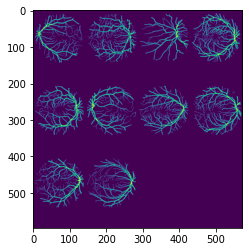

In [4]:
ds1, ds2 = icon_registration.data.get_dataset_retina(include_boundary=False, fixed_vertical_offset=200)

sample_batch = next(iter(ds1))[0]
plt.imshow(torchvision.utils.make_grid(sample_batch[:12], nrow=4)[0])

In [5]:
import alias_free_unet
import importlib
importlib.reload(alias_free_unet)
unet = alias_free_unet.GenericUNet(
    input_channels=1, 
    output_channels=64, 
    num_layers=3,
    channels=[[None, 16, 32, 64], [16, 32, 64]],
    init_zero=False, 
    regis_scale=False)

unet = alias_free_unet.NoDownsampleNet()
unet.cuda()
image_A = sample_batch.cuda()
ufeatures = unet(image_A)

In [6]:
class AttentionRegistration(icon_registration.RegistrationModule):
    def __init__(self, net):
        super().__init__()
        self.net = net
        self.dim = 128
        
        self.blur_kernel = torch.nn.Conv2d(2, 2, 5, padding="same", bias=False, groups=2)
    
    def featurize(self, values):       
        padding = 9
        x = torch.nn.functional.pad(values, [padding,padding,padding,padding])
        x = self.net(x)        
        x = 4 * x / (.001 + torch.sqrt(torch.sum(x**2, dim=1, keepdims=True)))        
        return x[:, :, padding:-padding, padding:-padding]
        
    
    def forward(self, A, B):
        ft_A = self.featurize(A)   
        ft_B = self.featurize(B)
               
        ft_A = ft_A.reshape(-1, self.dim, self.identity_map.shape[-1] * self.identity_map.shape[-2])
        ft_B = ft_B.reshape(-1, self.dim, self.identity_map.shape[-1] * self.identity_map.shape[-2])

        attention = torch.nn.functional.softmax((ft_B.permute(0, 2, 1) @ ft_A), dim=2)
        self.attention = attention
        x = self.identity_map.reshape(-1, 2, ft_A.shape[2])
        y = x.permute(0, 2, 1)
        output = attention @ y       
        output = output.permute(0, 2, 1)       
        output = output.reshape(-1, 2, self.identity_map.shape[2], self.identity_map.shape[3])       
        output = output      
        output = output  - self.identity_map  
        #output = self.blur_kernel(output)             
        return output
ar = AttentionRegistration(unet)
ar.cuda()
0

0

In [7]:
inner_net = icon.network_wrappers.DownsampleRegistration(
  icon.network_wrappers.DownsampleRegistration(
    icon.FunctionFromVectorField(ar), 2), 2)
inner_net.assign_identity_map(sample_batch.shape)
inner_net.cuda()
0

0

In [8]:
ts = icon.TwoStepRegistration(inner_net, icon.TwoStepRegistration(
    icon.FunctionFromVectorField(icon.networks.tallUNet2(dimension=2)),
    icon.FunctionFromVectorField(icon.networks.tallUNet2(dimension=2)))
                             )

net = icon.losses.DiffusionRegularizedNet(ts, icon.LNCC(sigma=4), lmbda=1.5)
net.assign_identity_map(sample_batch.shape)
net.cuda()
0

0

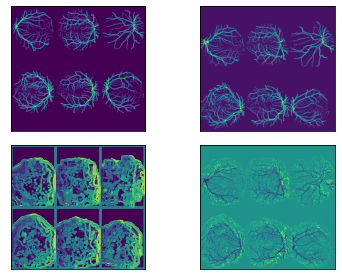

In [9]:
def show(tensor):
    plt.imshow(torchvision.utils.make_grid(tensor[:6], nrow=3)[0].cpu().detach())
    plt.xticks([])
    plt.yticks([])
image_A = next(iter(ds1))[0].to(device)
image_B = next(iter(ds2))[0].to(device)
net(image_A, image_B)
plt.subplot(2, 2, 1)
show(image_A)
plt.subplot(2, 2, 2)
show(image_B)
plt.subplot(2, 2, 3)
show(net.warped_image_A)
plt.contour(torchvision.utils.make_grid(net.phi_AB_vectorfield[:6], nrow=3)[0].cpu().detach())
plt.contour(torchvision.utils.make_grid(net.phi_AB_vectorfield[:6], nrow=3)[1].cpu().detach())
plt.subplot(2, 2, 4)
show(net.warped_image_A - image_B)
plt.tight_layout()



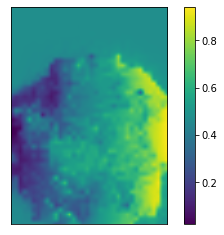

In [10]:
show(net.phi_AB_vectorfield[:, 1])
plt.colorbar()

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [01:09<00:00, 13.95s/it]


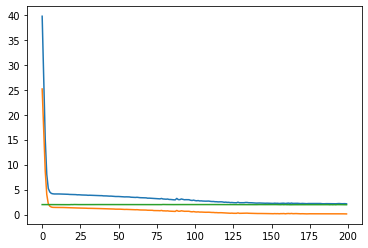

In [11]:
net.train()
net.to(device)
optim = torch.optim.Adam(net.parameters(), lr=0.0003)
curves = icon.train_datasets(net, optim, ds1, ds2, epochs=5)
plt.close()
plt.plot(np.array(curves)[:, :3])



100%|█████████████████████████████████████████████████████████████████████████████████| 45/45 [10:41<00:00, 14.26s/it]


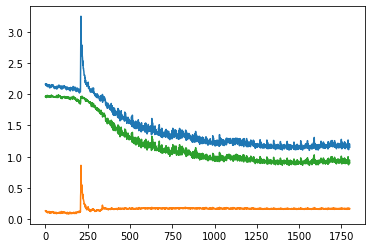

In [12]:
curves = icon.train_datasets(net, optim, ds1, ds2, epochs=45)
plt.close()
plt.plot(np.array(curves)[:, :3])


In [13]:
curves = icon.train_datasets(net, optim, ds1, ds2, epochs=45)
plt.close()
plt.plot(np.array(curves)[:, :3])


  0%|                                                                                          | 0/45 [00:07<?, ?it/s]


KeyboardInterrupt: 

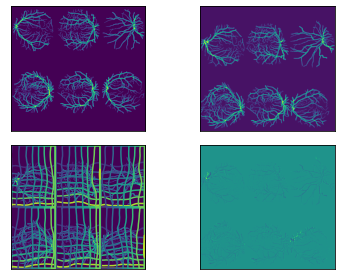

In [14]:
def show(tensor):
    plt.imshow(torchvision.utils.make_grid(tensor[:6], nrow=3)[0].cpu().detach())
    plt.xticks([])
    plt.yticks([])
image_A = next(iter(ds1))[0].to(device)
image_B = next(iter(ds2))[0].to(device)
net(image_A, image_B)
plt.subplot(2, 2, 1)
show(image_A)
plt.subplot(2, 2, 2)
show(image_B)
plt.subplot(2, 2, 3)
show(net.warped_image_A)
plt.contour(torchvision.utils.make_grid(net.phi_AB_vectorfield[:6], nrow=3)[0].cpu().detach())
plt.contour(torchvision.utils.make_grid(net.phi_AB_vectorfield[:6], nrow=3)[1].cpu().detach())
plt.subplot(2, 2, 4)
show(net.warped_image_A - image_B)
plt.tight_layout()

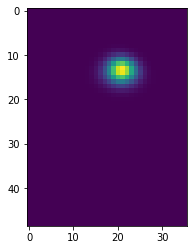

In [63]:
plt.imshow(ar.attention.cpu().detach()[0, 956].reshape(ar.identity_map.shape[2], ar.identity_map.shape[3]))

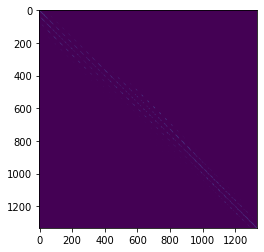

In [218]:
plt.imshow(ar.attention.cpu().detach()[0])

In [219]:
import math
math.sqrt(1332.)

36.49657518178932

In [109]:
37 * 36

1332